## DSC 478 Water Pump Classifier Project Notebook 7

### Water Pump Stacking Classifier - Boudart

This notebook aims to develop a stacking classifier comprised of all the best individual classifier models built in previous notebooks. We hope the blended models will improve upon the results of each model individually.

In [ ]:
import numpy as np
import pandas as pd
import pickle 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
import warnings

In [ ]:
# Block warning for model being from a different version of sklearn
warnings.filterwarnings('ignore')

# Load pickles of best classifiers developed
# Loading KNN pickle. 
with open('knn_final.pkl', 'rb') as pickle_file:
    knnClf = pickle.load(pickle_file)

# Loading Decision Tree pickle. 
with open('treeclf_final.pkl', 'rb') as pickle_file:
    dtClf = pickle.load(pickle_file)

# Loading Random Forest pickle. 
with open('rf_final.pkl', 'rb') as pickle_file:
    rfClf = pickle.load(pickle_file)

# Loading AdaBoost pickle. 
with open('ab_final.pkl', 'rb') as pickle_file:
    aDaClf = pickle.load(pickle_file)

In [ ]:
# Format output of data frame. 
pd.set_option("precision", 4)
pd.set_option('display.max_columns', None)

### Data Preperation

The data is loaded into a pandas data frame then split into a training and testing set with 80% in the training set and 20% in the testing set. 

In [ ]:
# Read datasets into pandas data frames. 
wp = pd.read_csv('../data/pump_train_final_reduced.csv')

# Split attributes from target class
wp_target = wp.iloc[:,-1]
wp = wp.iloc[:,:-1]

In [ ]:
wp_dum = pd.get_dummies(wp)

# Review table as dummies
wp_dum

,gps_height,population,public_meeting,permit,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_type_annually,payment_type_monthly,payment_type_never pay,payment_type_on failure,payment_type_other,payment_type_per bucket,payment_type_unknown,quality_group_colored,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_group_dry,quantity_group_enough,quantity_group_insufficient,quantity_group_seasonal,quantity_group_unknown,source_type_borehole,source_type_dam,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,1390.0000,109.000,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,1399.0000,280.000,0.0,1.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
2,686.0000,250.000,1.0,1.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,263.0000,58.000,1.0,1.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,668.2972,200.875,1.0,1.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50374,540.0000,210.000,1.0,1.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
50375,351.0000,89.000,1.0,1.0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
50376,1210.0000,125.000,1.0,1.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
50377,1212.0000,56.000,1.0,1.0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [ ]:
wp_train, wp_test, wp_target_train, wp_target_test = train_test_split(wp_dum, wp_target, test_size=0.2, random_state=210)

### Functions

The following functions will be used throughout the stacking analysis that follows.

The runStackingModel function initialized and fits the Stacking ensemble model. It then makes predictions for the training and testing set and calculates their corresponding accuracies. The predictions and accuracies for each set are returned. 

In [ ]:
def runStackingModel(train, test, target_train, target_test, estimators, finalEstimator): 
    """Returns predicted values for training and testing set, along with the model's accruacy for both."""
    
    # Initialize and fit clustering model
    mdl = StackingClassifier(estimators=estimators, final_estimator=finalEstimator)
    mdl.fit(train, target_train)    
    predTrain = mdl.predict(train)
    predTest = mdl.predict(test)
    
    trainAcc = accuracy_score(target_train, predTrain)
    testAcc = accuracy_score(target_test, predTest)
    
    testBalAcc = balanced_accuracy_score(target_test, predTest)
    
    return predTrain, predTest, trainAcc, testAcc, testBalAcc

The printStackingStats function prints the accuracy of each set and calculates the difference. It also prints the classification report, produces a graph of the confusion matrix, and print the testing set's balanced accuracy. 

In [ ]:
def printStackingStats(trainAcc, testAcc, testBalAcc, wp_target_test, predTest):
    """Prints KNN results and confusion matrix."""
    print('The training set accuracy is equal to ' + str(round(trainAcc*100,2)) + '%.')
    print('The testing set accuracy is equal to ' + str(round(testAcc*100,2)) + '%.')
    print('The difference is ' + str(round((trainAcc-testAcc)*100,2)) + '%.\n')
    print(classification_report(wp_target_test, predTest))
    
    cm = confusion_matrix(wp_target_test, predTest)  # Obtain confusion Matrix
    
    #Format and graph confusion matrix
    fig, ax = plt.subplots(figsize=(5.75, 5.75))
    ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix - Test', fontsize=18)
    ax.xaxis.set_ticks_position("bottom")
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1,2])
    ax.set_xticklabels(['functional','functional needs repair', 'non functional'])
    ax.set_yticklabels(['functional','functional needs repair', 'non functional'])
    plt.show()
    
    print('\nThe testing set\'s balanced accuracy is ' + str(round(testBalAcc*100,2)) + '%.')
       
    return

## Stacking Classifier Analysis

### Scale data for only models that require it (KNN)

The following code tests the best models with only scaling the data for models that require it, KNN. Four classifiers are tested as the final models. The four classifiers used as final estimators are not part of the stack. The final estimators include Logistic Regression, Gradient Boosting, categorical Naive Bayes, and Gaussian Naive Bayes. 

The training set accuracy is equal to 81.28%.
The testing set accuracy is equal to 77.28%.
The difference is 4.0%.

                         precision    recall  f1-score   support

             functional       0.75      0.91      0.83      5610
functional needs repair       0.55      0.14      0.23       734
         non functional       0.83      0.69      0.75      3732

               accuracy                           0.77     10076
              macro avg       0.71      0.58      0.60     10076
           weighted avg       0.77      0.77      0.75     10076



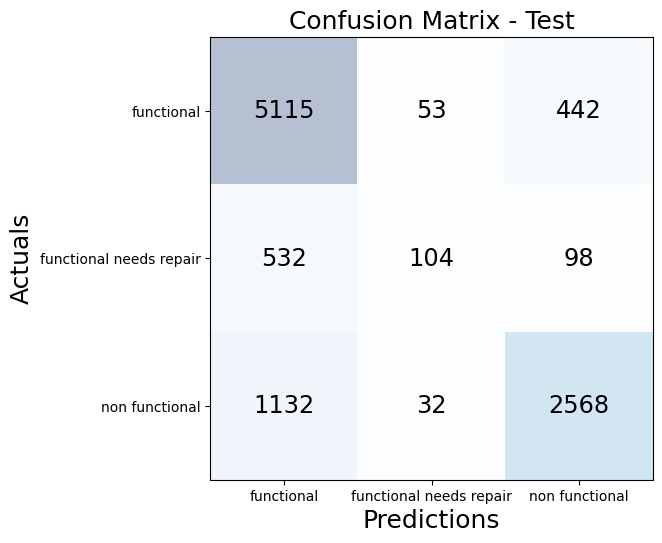


The testing set's balanced accuracy is 58.05%.


In [ ]:
estimators = [
    ('rf', rfClf),
    ('knn', make_pipeline(MinMaxScaler(), knnClf)),
    ('dt', dtClf), 
    ('Ada', aDaClf)]
     
finalEstimator = LogisticRegression(max_iter=10000)

predTrain, predTest, trainAcc, testAcc, testBalAcc = runStackingModel(wp_train, wp_test, wp_target_train, wp_target_test, estimators, finalEstimator)
printStackingStats(trainAcc, testAcc, testBalAcc, wp_target_test, predTest)

The training set accuracy is equal to 81.13%.
The testing set accuracy is equal to 77.26%.
The difference is 3.87%.

                         precision    recall  f1-score   support

             functional       0.75      0.91      0.82      5610
functional needs repair       0.54      0.16      0.25       734
         non functional       0.83      0.69      0.75      3732

               accuracy                           0.77     10076
              macro avg       0.71      0.59      0.61     10076
           weighted avg       0.77      0.77      0.76     10076



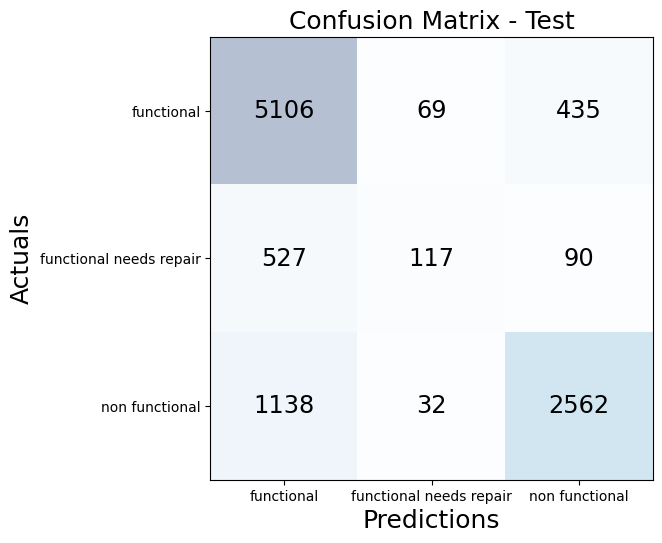


The testing set's balanced accuracy is 58.54%.


In [ ]:
estimators = [
    ('rf', rfClf),
    ('knn', make_pipeline(MinMaxScaler(), knnClf)),
    ('dt', dtClf), 
    ('Ada', aDaClf)]
     
finalEstimator = GradientBoostingClassifier()

predTrain, predTest, trainAcc, testAcc, testBalAcc = runStackingModel(wp_train, wp_test, wp_target_train, wp_target_test, estimators, finalEstimator)
printStackingStats(trainAcc, testAcc, testBalAcc, wp_target_test, predTest)

The training set accuracy is equal to 75.83%.
The testing set accuracy is equal to 73.12%.
The difference is 2.7%.

                         precision    recall  f1-score   support

             functional       0.68      0.98      0.80      5610
functional needs repair       0.62      0.04      0.08       734
         non functional       0.93      0.50      0.65      3732

               accuracy                           0.73     10076
              macro avg       0.74      0.51      0.51     10076
           weighted avg       0.77      0.73      0.69     10076



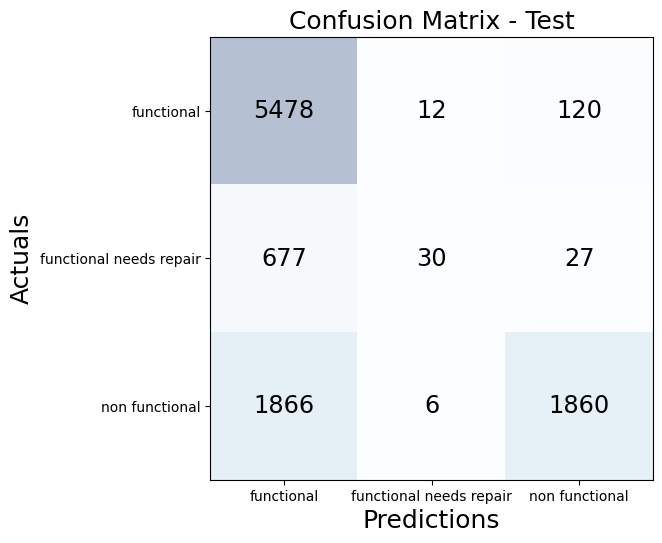


The testing set's balanced accuracy is 50.52%.


In [ ]:
estimators = [
    ('rf', rfClf),
    ('knn', make_pipeline(MinMaxScaler(), knnClf)),
    ('dt',dtClf), 
    ('aDa',aDaClf)]
     
finalEstimator = CategoricalNB()

predTrain, predTest, trainAcc, testAcc, testBalAcc = runStackingModel(wp_train, wp_test, wp_target_train, wp_target_test, estimators, finalEstimator)
printStackingStats(trainAcc, testAcc, testBalAcc, wp_target_test, predTest)

The training set accuracy is equal to 80.31%.
The testing set accuracy is equal to 75.89%.
The difference is 4.42%.

                         precision    recall  f1-score   support

             functional       0.77      0.86      0.81      5610
functional needs repair       0.35      0.40      0.38       734
         non functional       0.84      0.67      0.75      3732

               accuracy                           0.76     10076
              macro avg       0.66      0.65      0.65     10076
           weighted avg       0.77      0.76      0.76     10076



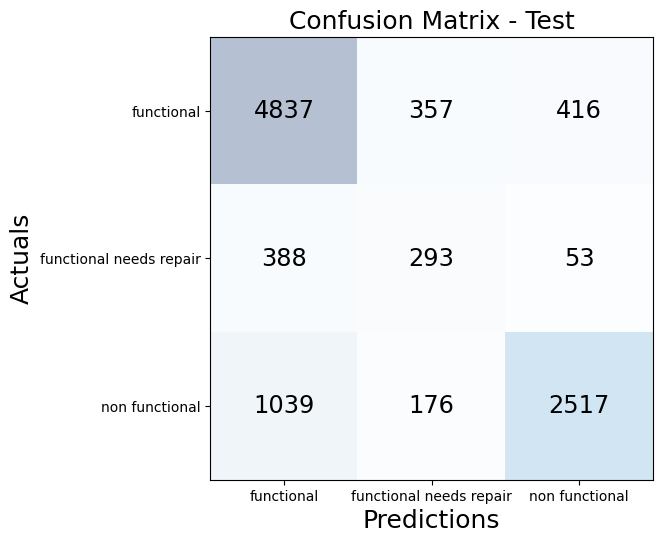


The testing set's balanced accuracy is 64.53%.


In [ ]:
estimators = [
    ('rf', rfClf),
    ('knn', make_pipeline(MinMaxScaler(), knnClf)),
    ('dt',dtClf), 
    ('aDa',aDaClf)]
     
finalEstimator = GaussianNB()

predTrain, predTest, trainAcc, testAcc, testBalAcc = runStackingModel(wp_train, wp_test, wp_target_train, wp_target_test, estimators, finalEstimator)
printStackingStats(trainAcc, testAcc, testBalAcc, wp_target_test, predTest)

The final estimator that performed best on this data was the Gaussian Naive Bayes. Although it did not have the best testing set accuracy, it achieved the best testing set balanced accuracy and precision for the functional class. The best attributes achieved by the Gaussian Naive Bayes final estimator are most desirable because the data has a class imbalance and allows water pump inspectors to be confident about the functional predictions so they can focus their attention on the water pumps predicted as one of the other two classes. 

### Scale data for all classifiers

The testing conducted above is repeated below but after MinMax scaling all the data for all classifiers in the stack. 

In [ ]:
# Scale data using min-max scaling.
scaler = MinMaxScaler()
scaler.fit(wp_dum)
wp_dum = scaler.transform(wp_dum)

In [ ]:
wp_train, wp_test, wp_target_train, wp_target_test = train_test_split(wp_dum, wp_target, test_size=0.2, random_state=210)

The training set accuracy is equal to 81.28%.
The testing set accuracy is equal to 77.52%.
The difference is 3.76%.

                         precision    recall  f1-score   support

             functional       0.76      0.91      0.83      5610
functional needs repair       0.57      0.16      0.26       734
         non functional       0.83      0.69      0.75      3732

               accuracy                           0.78     10076
              macro avg       0.72      0.59      0.61     10076
           weighted avg       0.77      0.78      0.76     10076



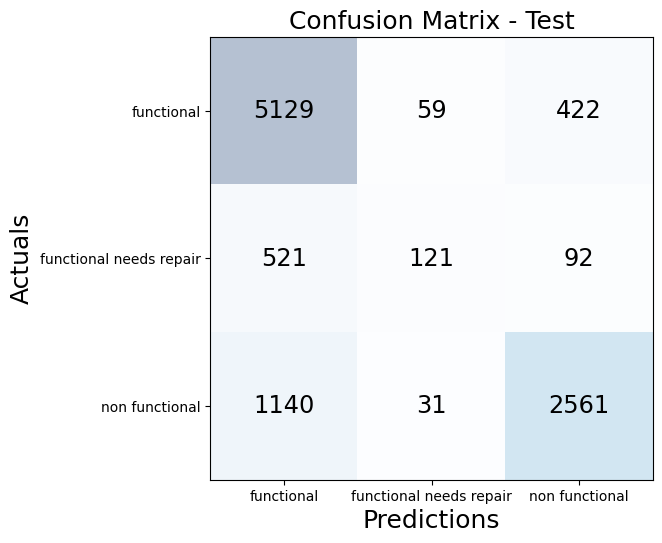


The testing set's balanced accuracy is 58.84%.


In [ ]:
estimators = [
    ('rf', rfClf),
    ('knn', knnClf),
    ('dt',dtClf), 
    ('aDa',aDaClf)]
     
finalEstimator = LogisticRegression(max_iter=10000)

predTrain, predTest, trainAcc, testAcc, testBalAcc = runStackingModel(wp_train, wp_test, wp_target_train, wp_target_test, estimators, finalEstimator)
printStackingStats(trainAcc, testAcc, testBalAcc, wp_target_test, predTest)

The training set accuracy is equal to 81.14%.
The testing set accuracy is equal to 77.33%.
The difference is 3.81%.

                         precision    recall  f1-score   support

             functional       0.75      0.92      0.83      5610
functional needs repair       0.57      0.13      0.21       734
         non functional       0.83      0.68      0.75      3732

               accuracy                           0.77     10076
              macro avg       0.72      0.58      0.59     10076
           weighted avg       0.77      0.77      0.75     10076



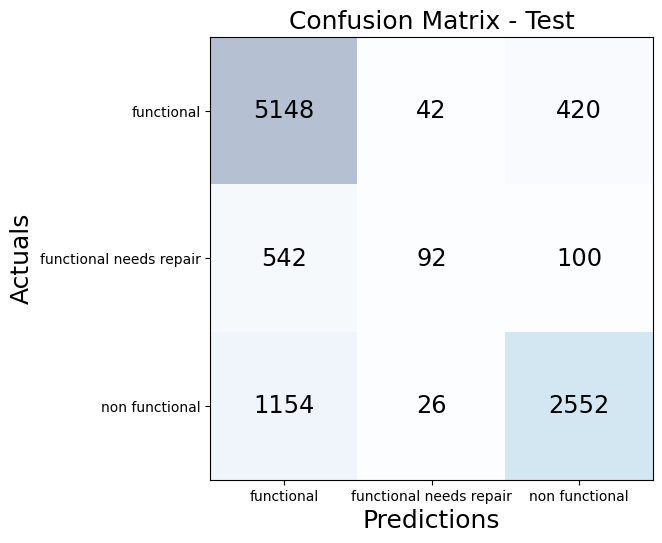


The testing set's balanced accuracy is 57.56%.


In [ ]:
estimators = [
    ('rf', rfClf),
    ('knn', knnClf),
    ('dt',dtClf), 
    ('aDa',aDaClf)]
     
finalEstimator = GradientBoostingClassifier()

predTrain, predTest, trainAcc, testAcc, testBalAcc = runStackingModel(wp_train, wp_test, wp_target_train, wp_target_test, estimators, finalEstimator)
printStackingStats(trainAcc, testAcc, testBalAcc, wp_target_test, predTest)

The training set accuracy is equal to 75.78%.
The testing set accuracy is equal to 73.09%.
The difference is 2.69%.

                         precision    recall  f1-score   support

             functional       0.68      0.98      0.80      5610
functional needs repair       0.71      0.05      0.09       734
         non functional       0.92      0.50      0.65      3732

               accuracy                           0.73     10076
              macro avg       0.77      0.51      0.51     10076
           weighted avg       0.77      0.73      0.69     10076



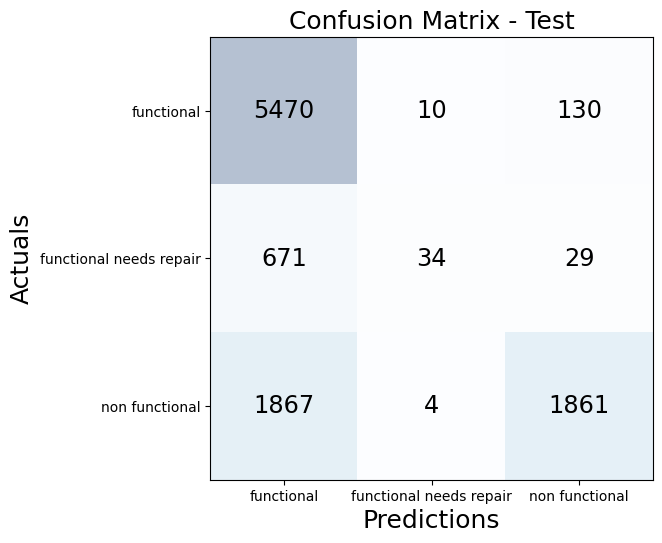


The testing set's balanced accuracy is 50.67%.


In [ ]:
estimators = [
    ('rf', rfClf),
    ('knn', knnClf),
    ('dt',dtClf), 
    ('aDa',aDaClf)]
     
finalEstimator = CategoricalNB()

predTrain, predTest, trainAcc, testAcc, testBalAcc = runStackingModel(wp_train, wp_test, wp_target_train, wp_target_test, estimators, finalEstimator)
printStackingStats(trainAcc, testAcc, testBalAcc, wp_target_test, predTest)

The training set accuracy is equal to 80.52%.
The testing set accuracy is equal to 75.92%.
The difference is 4.6%.

                         precision    recall  f1-score   support

             functional       0.77      0.87      0.81      5610
functional needs repair       0.36      0.39      0.38       734
         non functional       0.84      0.67      0.75      3732

               accuracy                           0.76     10076
              macro avg       0.66      0.64      0.65     10076
           weighted avg       0.77      0.76      0.76     10076



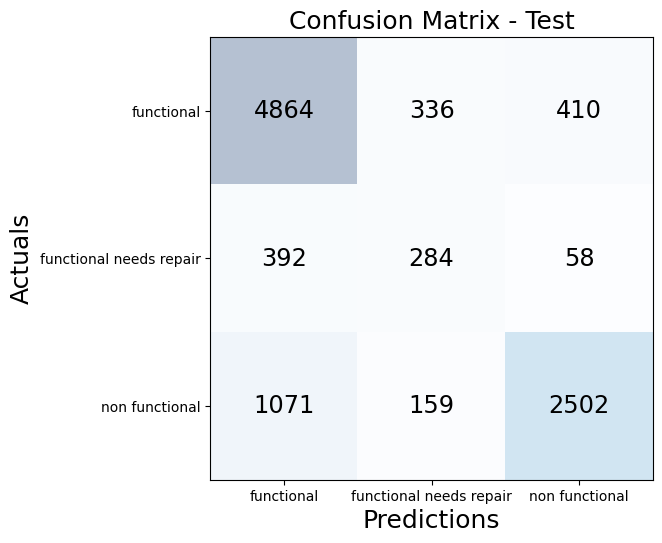


The testing set's balanced accuracy is 64.15%.


In [ ]:
estimators = [
    ('rf', rfClf),
    ('knn', knnClf),
    ('dt',dtClf), 
    ('aDa',aDaClf)]
     
finalEstimator = GaussianNB()

predTrain, predTest, trainAcc, testAcc, testBalAcc = runStackingModel(wp_train, wp_test, wp_target_train, wp_target_test, estimators, finalEstimator)
printStackingStats(trainAcc, testAcc, testBalAcc, wp_target_test, predTest)

The results from scaling all the data is similar to scaling only KNN in the previous section. The best classifier is again the one that uses the Gaussian Naive Bayes final estimator. However, it performed slightly worst than it did when only the KNN data was scaled. 

In [ ]:
# Best stacking model
estimators = [
    ('rf', rfClf),
    ('knn', make_pipeline(MinMaxScaler(), knnClf)),
    ('dt',dtClf), 
    ('aDa',aDaClf)]
     
finalEstimator = GaussianNB()

stacking_final = StackingClassifier(estimators=estimators, final_estimator=finalEstimator)
stacking_final = stacking_final.fit(wp_train, wp_target_train)

# Write pickle
with open('stacking_final.pkl', 'wb') as pickle_file:
    pickle.dump(stacking_final, pickle_file)